In [1]:
import sys

sys.path.insert(1, "../")

In [2]:
from em_algo.models import WeibullModelExp, GaussianModel, ExponentialModel
from em_algo.types import *
from em_algo import MixtureDistribution, DistributionInMixture
from examples.utils import SingleSolverResult

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import itertools

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

In [3]:
from examples.utils import *
from examples.prepare_result import prepare
from examples.config import RESULTS_FOLDER
import os.path

In [4]:
TEST_NAME = "big_mono_test"
SAVE_CSV = True

In [5]:
if os.path.isfile(RESULTS_FOLDER / (TEST_NAME + ".csv")):
    print(f"loading from file {TEST_NAME}.csv")
    df = pd.read_csv(RESULTS_FOLDER / (TEST_NAME + ".csv"))
elif os.path.isfile(RESULTS_FOLDER / (TEST_NAME + ".pkl")):
    print(f"loading and preparing from file {TEST_NAME}.pkl")
    print("this may take a time")
    results = open_results(TEST_NAME)
    df = prepare(results)
    results = []
    df["occur"] = df["occur"].replace([np.inf, -np.inf], np.nan)
    if SAVE_CSV:
        print(f"saving prepared table to {TEST_NAME}.csv")
        df.to_csv(RESULTS_FOLDER / (TEST_NAME + ".csv"))
else:
    print(
        f"there is no file named {RESULTS_FOLDER / TEST_NAME}.csv in folder examples\\results"
    )
    print(
        f"there is no file named {RESULTS_FOLDER / TEST_NAME}.pkl in folder examples\\results"
    )
    exit()

loading and preparing from file big_mono_test.pkl
this may take a time


  0%|          | 0/245760 [00:00<?, ?it/s]

saving prepared table to big_mono_test.csv


In [6]:
df["error"].unique()

array([None], dtype=object)

In [7]:
df = df.drop(columns=["error"])

In [8]:
df["success"] = (df["steps"] < 16) & any(df["result_mixture"].values)

In [9]:
df["success"].value_counts()

success
True     140976
False    104784
Name: count, dtype: int64

In [10]:
df["failed"].value_counts()

failed
False    240886
True       4874
Name: count, dtype: int64

In [11]:
df.head()

,test_index,optimizer,k,sample,true_mixture,result_mixture,log,steps,time,model,size,success,failed,occur
0,61439,ScipyCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],6,2.838619,Exponential,1000,True,False,1.798273
1,61439,ScipyNewtonCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],6,2.685353,Exponential,1000,True,False,1.798273
2,61439,ScipySLSQP,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],6,2.367593,Exponential,1000,True,False,1.798273
3,61439,ScipyTNC,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],6,3.113600,Exponential,1000,True,False,1.798273
4,61438,ScipyCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],9,4.160045,Exponential,1000,True,False,1.798301


In [12]:
df.select_dtypes(["number", "bool"])

,test_index,k,steps,time,size,success,failed,occur
0,61439,4,6,2.838619,1000,True,False,1.798273
1,61439,4,6,2.685353,1000,True,False,1.798273
2,61439,4,6,2.367593,1000,True,False,1.798273
3,61439,4,6,3.113600,1000,True,False,1.798273
4,61438,4,9,4.160045,1000,True,False,1.798301
...,...,...,...,...,...,...,...,...
245755,1,1,2,0.072471,50,True,False,1.345528
245756,0,1,2,0.088051,50,True,False,1.345529
245757,0,1,2,0.075754,50,True,False,1.345529
245758,0,1,2,0.072382,50,True,False,1.345531


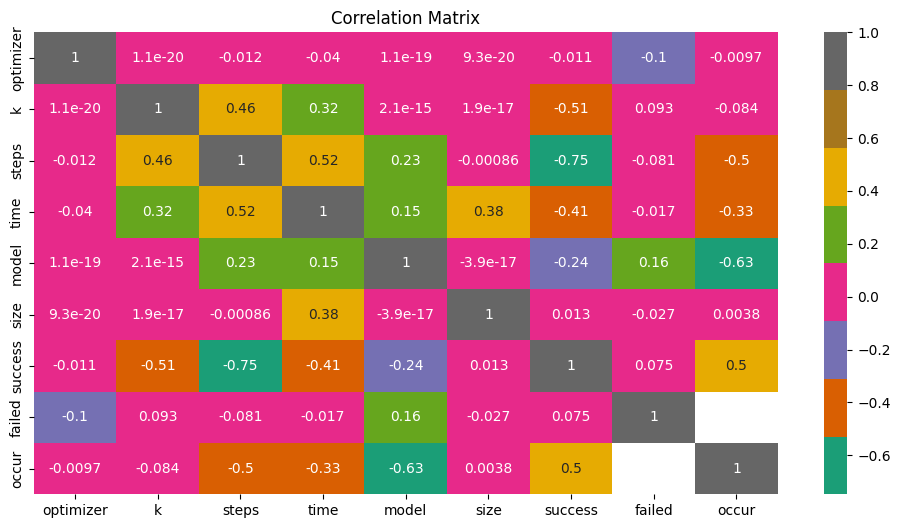

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
categorical_cols = (
    df.drop(columns=["true_mixture", "result_mixture", "sample", "log"])
    .select_dtypes(include=["object"])
    .columns
)

corr_df = pd.DataFrame(df)

for col in categorical_cols:
    corr_df[col] = le.fit_transform(df[col])

corr_df = corr_df.select_dtypes(["number", "bool"])
corr_df = corr_df.drop(columns=["test_index"])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
corr_df = pd.DataFrame(scaler.fit_transform(corr_df), columns=corr_df.columns)

df_corr = corr_df.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(df_corr, annot=True, cmap="Dark2")
plt.title("Correlation Matrix")
plt.show()

In [14]:
df[df["optimizer"] == "ScipyNewtonCG"]

,test_index,optimizer,k,sample,true_mixture,result_mixture,log,steps,time,model,size,success,failed,occur
1,61439,ScipyNewtonCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],6,2.685353,Exponential,1000,True,False,1.798273
5,61438,ScipyNewtonCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],9,5.123796,Exponential,1000,True,False,1.798301
9,61437,ScipyNewtonCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],12,3.678331,Exponential,1000,True,False,1.798300
13,61436,ScipyNewtonCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],11,5.308217,Exponential,1000,True,False,1.798260
17,61435,ScipyNewtonCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],4,1.847250,Exponential,1000,True,False,1.798102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245741,4,ScipyNewtonCG,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.039361,WeibullExp,50,True,False,1.345529
245745,3,ScipyNewtonCG,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.122396,WeibullExp,50,True,False,1.345529
245749,2,ScipyNewtonCG,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.082746,WeibullExp,50,True,False,1.345529
245753,1,ScipyNewtonCG,1,"[0.9173885735853511, 0.9069174216468057, 0.851...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],2,0.096762,WeibullExp,50,True,False,1.345529


In [15]:
for opt in df["optimizer"].unique():
    print(opt)
    print(df[df["optimizer"] == opt]["failed"].value_counts())
    print("time")
    print(df[df["optimizer"] == opt]["time"].mean())
    print("steps")
    print(df[df["optimizer"] == opt]["steps"].mean())
    print("occur")
    print(df[df["optimizer"] == opt]["occur"].mean())
    print()

ScipyCG
failed
False    58849
True      2591
Name: count, dtype: int64
time
27.403864059289965
steps
34.769710286458334
occur
-1.6684066557031507

ScipyNewtonCG
failed
False    60268
True      1172
Name: count, dtype: int64
time
21.19036805957167
steps
36.30042317708333
occur
-1.6945733720341623

ScipySLSQP
failed
False    60409
True      1031
Name: count, dtype: int64
time
16.636358142045697
steps
37.99287109375
occur
-1.7028354054676171

ScipyTNC
failed
False    61360
True        80
Name: count, dtype: int64
time
22.451693820360948
steps
32.55154622395833
occur
-1.7323861558039335



In [16]:
print(df["occur"].min())
print(df["occur"].max())

-15.257711644603747
2.1908783943300048


In [17]:
mdf = df[df["k"] > 1]
mdf

,test_index,optimizer,k,sample,true_mixture,result_mixture,log,steps,time,model,size,success,failed,occur
0,61439,ScipyCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],6,2.838619,Exponential,1000,True,False,1.798273
1,61439,ScipyNewtonCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],6,2.685353,Exponential,1000,True,False,1.798273
2,61439,ScipySLSQP,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],6,2.367593,Exponential,1000,True,False,1.798273
3,61439,ScipyTNC,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],6,3.113600,Exponential,1000,True,False,1.798273
4,61438,ScipyCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],9,4.160045,Exponential,1000,True,False,1.798301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225275,5121,ScipyTNC,2,"[4.302041539276377, 13.650895242057842, 6.3608...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],20,1.639677,WeibullExp,50,False,False,-2.583522
225276,5120,ScipyCG,2,"[4.302041539276377, 13.650895242057842, 6.3608...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],30,3.197858,WeibullExp,50,False,False,-2.585262
225277,5120,ScipyNewtonCG,2,"[4.302041539276377, 13.650895242057842, 6.3608...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],30,2.479588,WeibullExp,50,False,False,-2.585262
225278,5120,ScipySLSQP,2,"[4.302041539276377, 13.650895242057842, 6.3608...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],30,1.982855,WeibullExp,50,False,False,-2.585268


In [18]:
calc_success_rate_hash = dict()


def calc_success_rate(row, column):
    k = row["k"]
    size = row["size"]
    model = row["model"]
    optimizer = row["optimizer"]

    if (k, size, model, optimizer) in calc_success_rate_hash:
        return calc_success_rate_hash[(k, size, model, optimizer)]

    dfoi = mdf[
        (mdf["k"] == k)
        & (mdf["size"] == size)
        & (mdf["model"] == model)
        & (mdf["optimizer"] == optimizer)
    ]

    calc_success_rate_hash[(k, size, model, optimizer)] = (
        dfoi[column].sum() / len(dfoi) * 100
    )

    return calc_success_rate_hash[(k, size, model, optimizer)]


mdf["success_rate"] = mdf.apply(partial(calc_success_rate, column="success"), axis=1)
calc_success_rate_hash = dict()
mdf["fail_rate"] = mdf.apply(partial(calc_success_rate, column="failed"), axis=1)

C:\Users\toxakaz\AppData\Local\Temp\ipykernel_33588\4002064490.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf["success_rate"] = mdf.apply(partial(calc_success_rate, column="success"), axis=1)
C:\Users\toxakaz\AppData\Local\Temp\ipykernel_33588\4002064490.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf["fail_rate"] = mdf.apply(partial(calc_success_rate, column="failed"), axis=1)


In [19]:
mdf

,test_index,optimizer,k,sample,true_mixture,result_mixture,log,steps,time,model,size,success,failed,occur,success_rate,fail_rate
0,61439,ScipyCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],6,2.838619,Exponential,1000,True,False,1.798273,81.152344,0.000000
1,61439,ScipyNewtonCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],6,2.685353,Exponential,1000,True,False,1.798273,81.152344,0.000000
2,61439,ScipySLSQP,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],6,2.367593,Exponential,1000,True,False,1.798273,81.054688,0.000000
3,61439,ScipyTNC,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],6,3.113600,Exponential,1000,True,False,1.798273,81.152344,0.000000
4,61438,ScipyCG,4,"[0.06722615589584872, 0.0514443728976166, 0.01...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],9,4.160045,Exponential,1000,True,False,1.798301,81.152344,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225275,5121,ScipyTNC,2,"[4.302041539276377, 13.650895242057842, 6.3608...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],20,1.639677,WeibullExp,50,False,False,-2.583522,64.550781,0.488281
225276,5120,ScipyCG,2,"[4.302041539276377, 13.650895242057842, 6.3608...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],30,3.197858,WeibullExp,50,False,False,-2.585262,65.917969,11.328125
225277,5120,ScipyNewtonCG,2,"[4.302041539276377, 13.650895242057842, 6.3608...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],30,2.479588,WeibullExp,50,False,False,-2.585262,59.765625,3.906250
225278,5120,ScipySLSQP,2,"[4.302041539276377, 13.650895242057842, 6.3608...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],30,1.982855,WeibullExp,50,False,False,-2.585268,63.183594,4.785156


Exponential


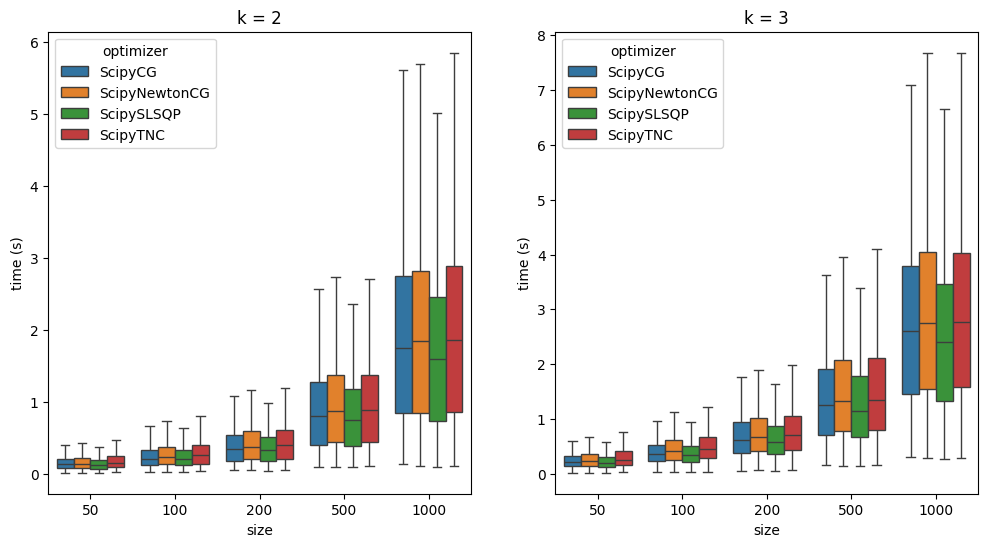

Exponential


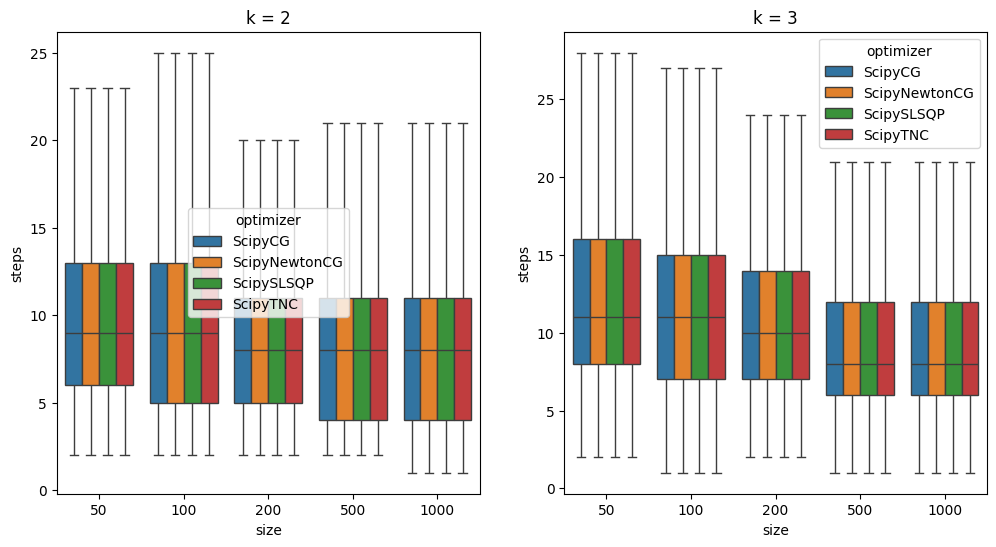

Exponential


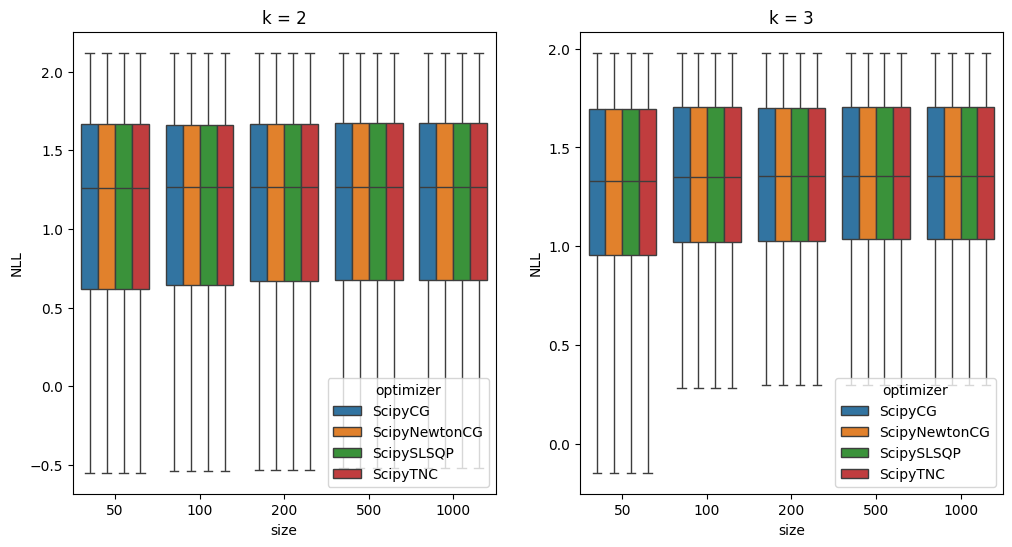

Exponential


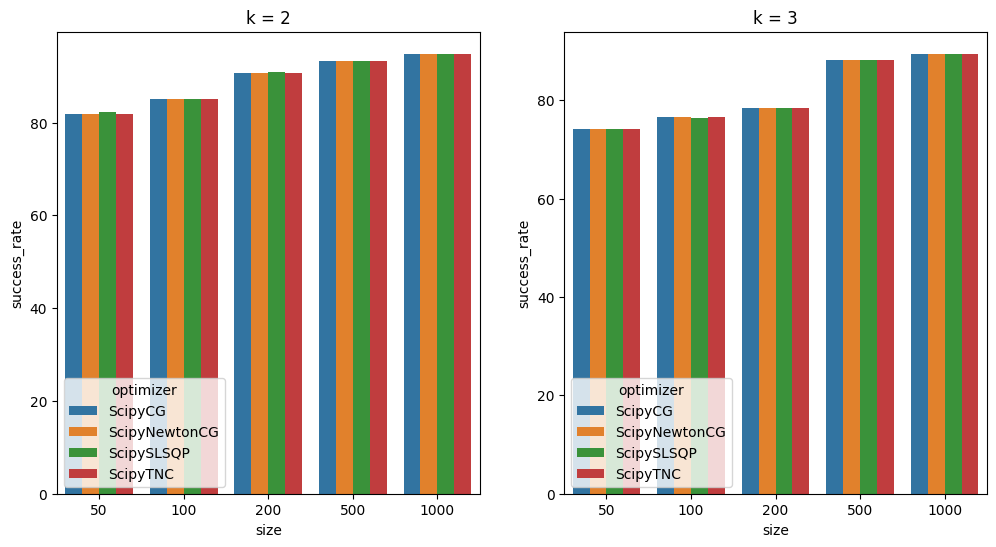

Exponential


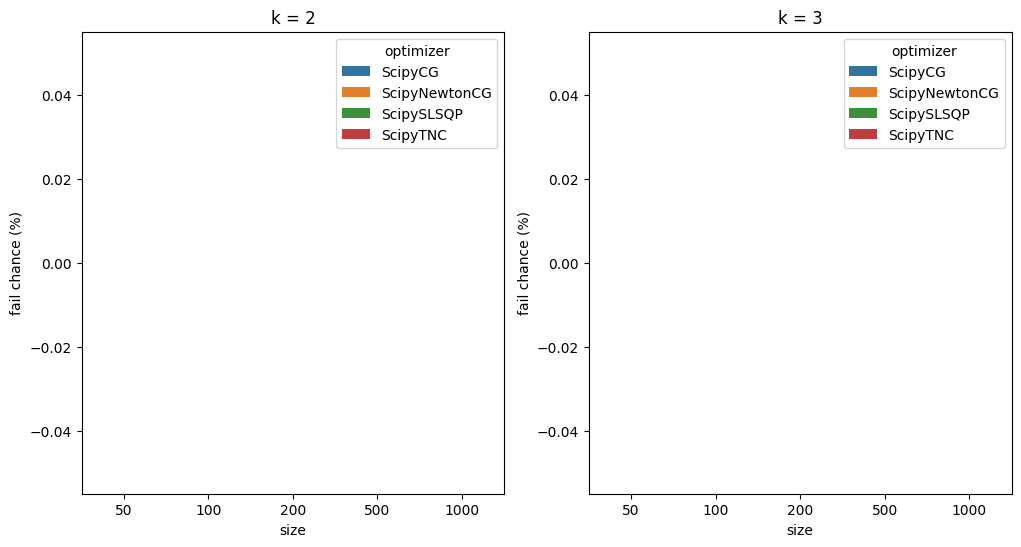

Gaussian


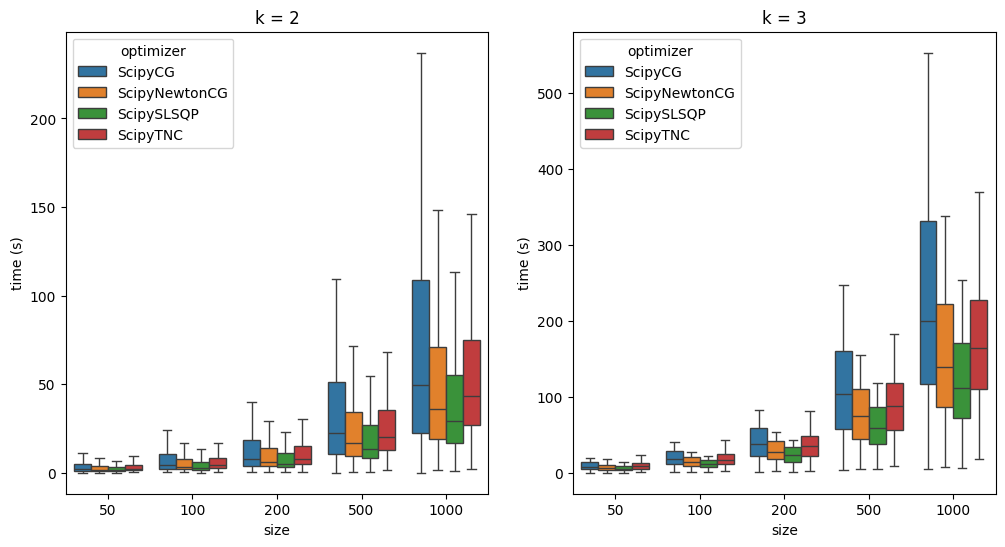

Gaussian


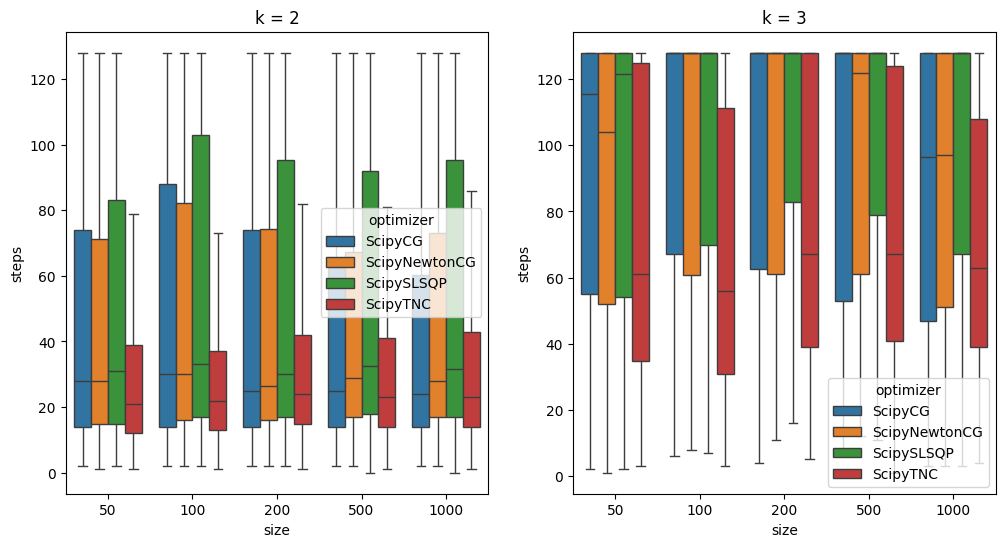

Gaussian


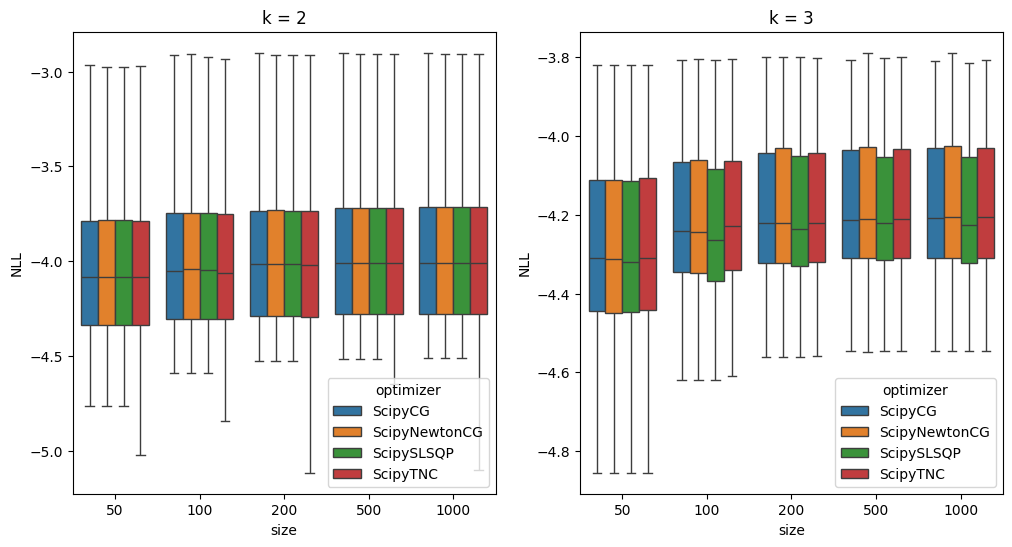

Gaussian


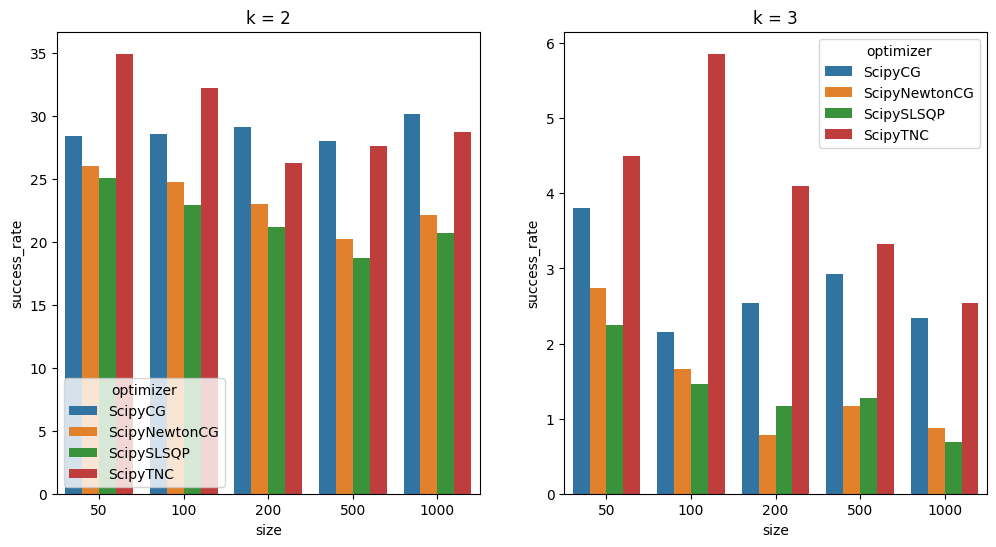

Gaussian


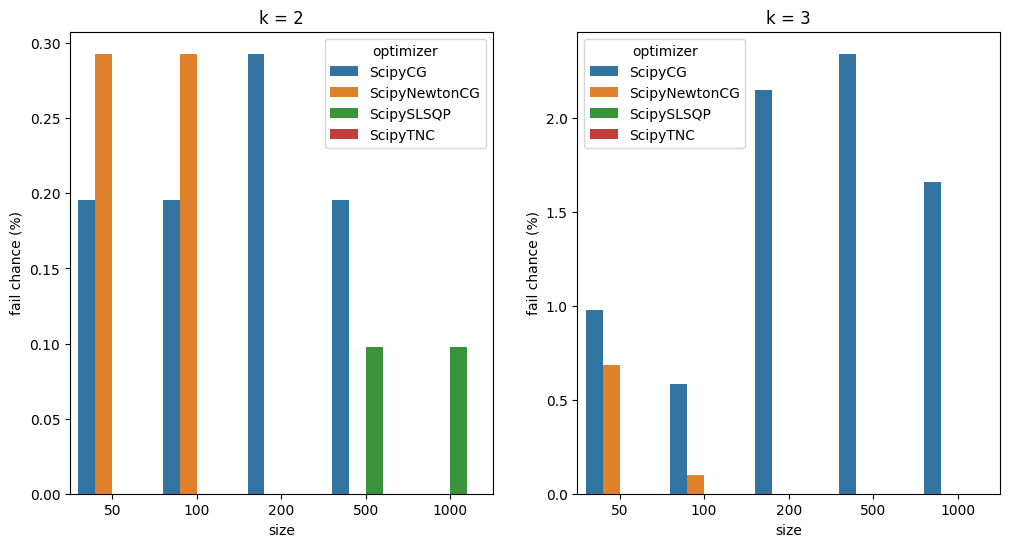

WeibullExp


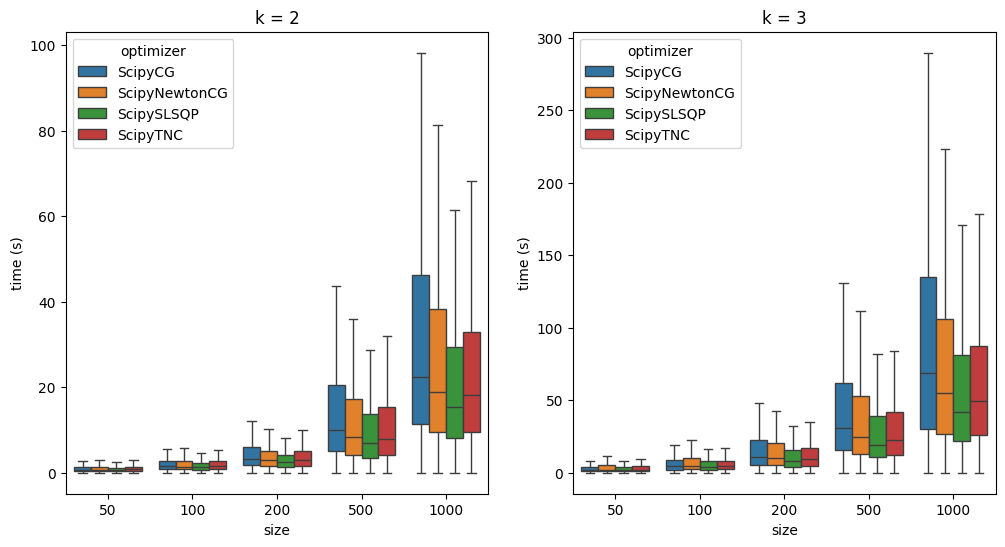

WeibullExp


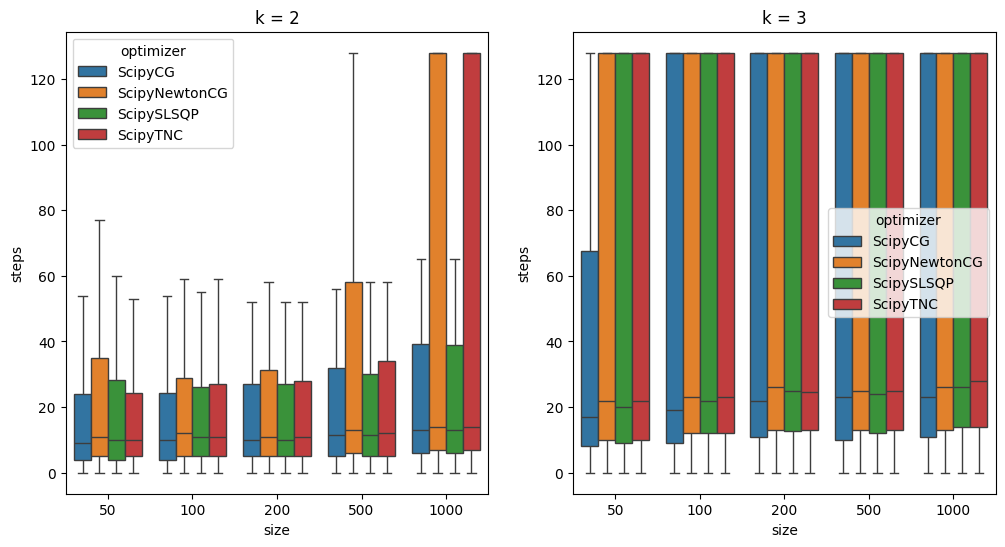

WeibullExp


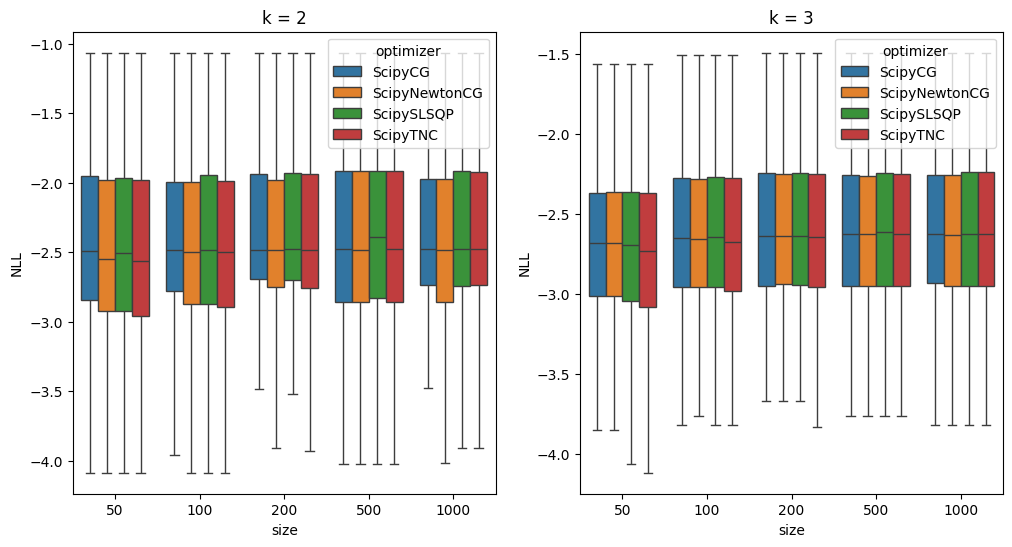

WeibullExp


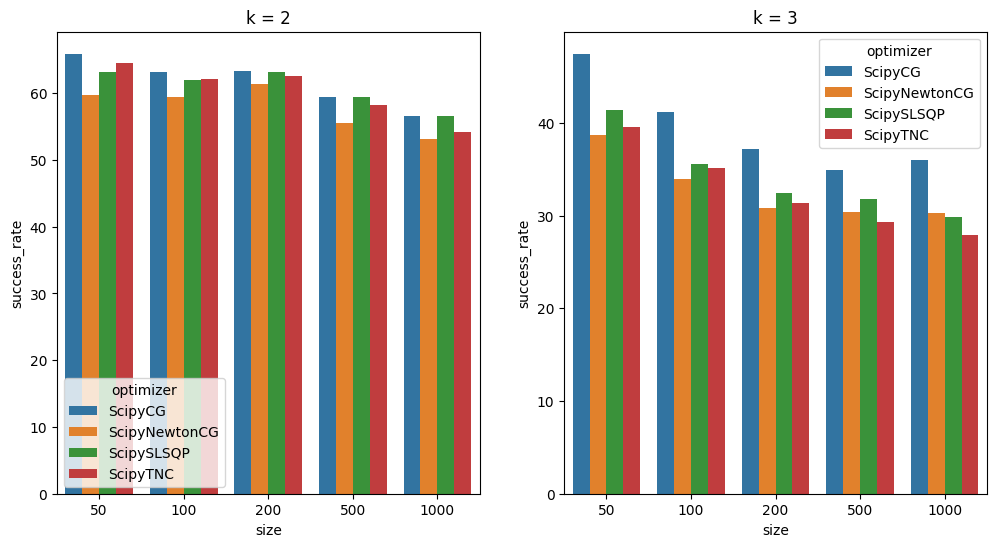

WeibullExp


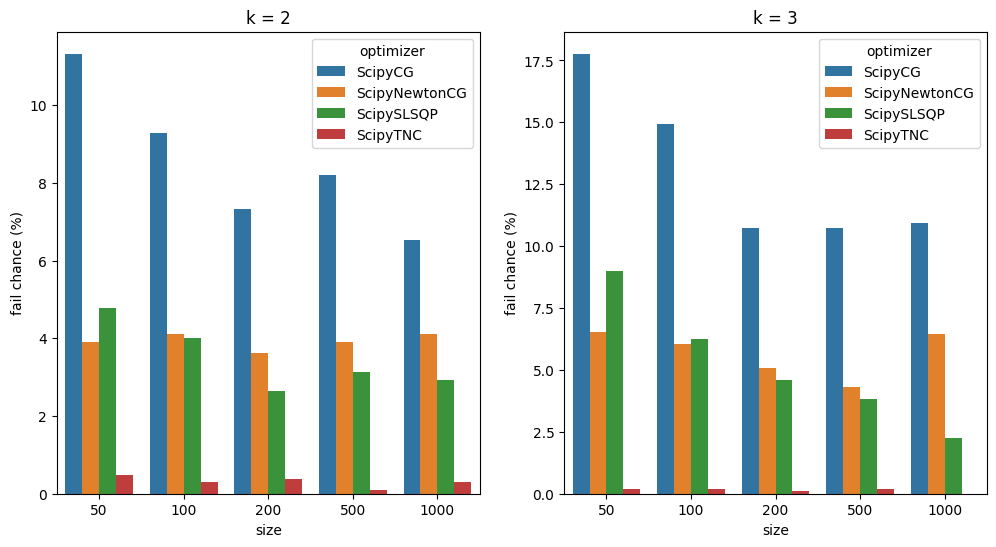

In [20]:
for model in mdf["model"].unique():
    cdf = mdf[mdf["model"] == model]
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sns.boxplot(
        ax=axs[0],
        data=cdf[cdf["k"] == 2],
        x="size",
        y="time",
        hue="optimizer",
        showfliers=False,
    )
    sns.boxplot(
        ax=axs[1],
        data=cdf[cdf["k"] == 3],
        x="size",
        y="time",
        hue="optimizer",
        showfliers=False,
    )
    axs[0].set_title("k = 2")
    axs[0].set_ylabel("time (s)")
    # axs[0].set_yscale("log")
    axs[1].set_title("k = 3")
    axs[1].set_ylabel("time (s)")
    # axs[1].set_yscale("log")
    print(model)
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sns.boxplot(
        ax=axs[0],
        data=cdf[cdf["k"] == 2],
        x="size",
        y="steps",
        hue="optimizer",
        showfliers=False,
    )
    sns.boxplot(
        ax=axs[1],
        data=cdf[cdf["k"] == 3],
        x="size",
        y="steps",
        hue="optimizer",
        showfliers=False,
    )
    axs[0].set_title("k = 2")
    axs[0].set_ylabel("steps")
    axs[1].set_title("k = 3")
    axs[1].set_ylabel("steps")
    print(model)
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sns.boxplot(
        ax=axs[0],
        data=cdf[cdf["k"] == 2],
        x="size",
        y="occur",
        hue="optimizer",
        showfliers=False,
    )
    sns.boxplot(
        ax=axs[1],
        data=cdf[cdf["k"] == 3],
        x="size",
        y="occur",
        hue="optimizer",
        showfliers=False,
    )
    axs[0].set_title("k = 2")
    axs[0].set_ylabel("NLL")
    axs[1].set_title("k = 3")
    axs[1].set_ylabel("NLL")
    print(model)
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].set_title("k = 2")
    axs[1].set_title("k = 3")
    sns.barplot(
        ax=axs[0],
        data=cdf[cdf["k"] == 2],
        x="size",
        y="success_rate",
        hue="optimizer",
    )
    sns.barplot(
        ax=axs[1],
        data=cdf[cdf["k"] == 3],
        x="size",
        y="success_rate",
        hue="optimizer",
    )
    print(model)
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sns.barplot(
        ax=axs[0],
        data=cdf[cdf["k"] == 2],
        x="size",
        y="fail_rate",
        hue="optimizer",
    )
    sns.barplot(
        ax=axs[1],
        data=cdf[cdf["k"] == 3],
        x="size",
        y="fail_rate",
        hue="optimizer",
    )
    axs[0].set_title("k = 2")
    axs[0].set_ylabel("fail chance (%)")
    axs[1].set_title("k = 3")
    axs[1].set_ylabel("fail chance (%)")
    print(model)
    plt.show()

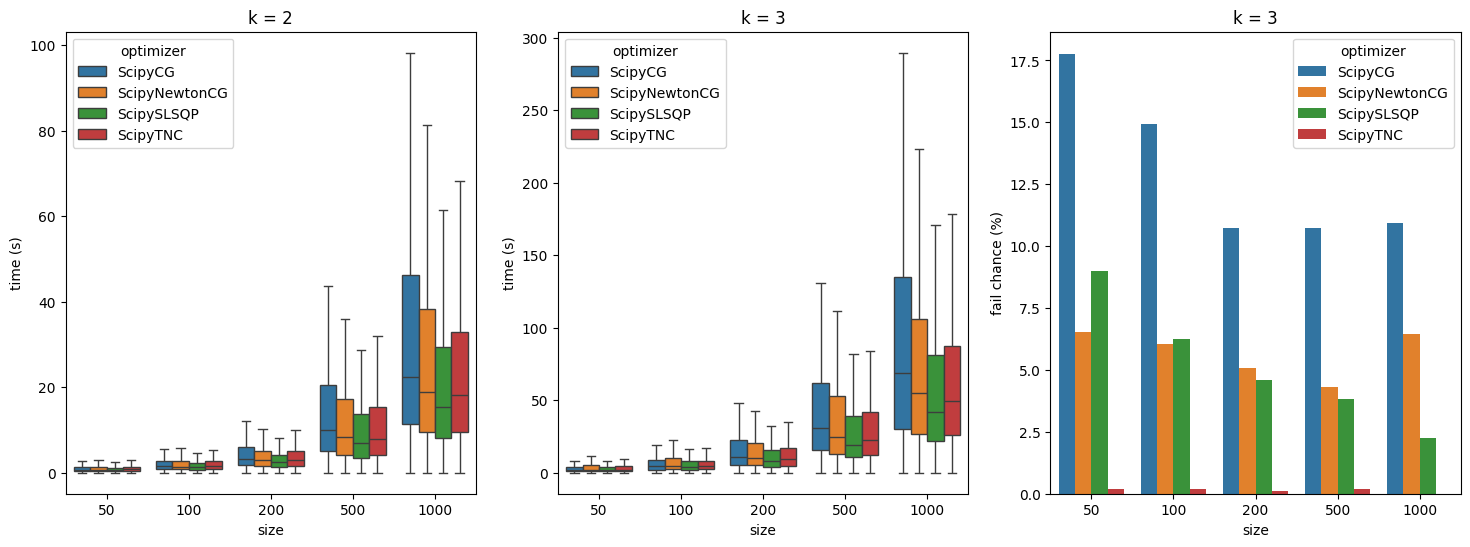

In [21]:
cdf = mdf[mdf["model"] == "WeibullExp"]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# fig.suptitle(model)
sns.boxplot(
    ax=axs[0],
    data=cdf[cdf["k"] == 2],
    x="size",
    y="time",
    hue="optimizer",
    showfliers=False,
)
sns.boxplot(
    ax=axs[1],
    data=cdf[cdf["k"] == 3],
    x="size",
    y="time",
    hue="optimizer",
    showfliers=False,
)

sns.barplot(
    ax=axs[2],
    data=cdf[cdf["k"] == 3],
    x="size",
    y="fail_rate",
    hue="optimizer",
)


axs[0].set_title("k = 2")
axs[0].set_ylabel("time (s)")
axs[1].set_title("k = 3")
axs[1].set_ylabel("time (s)")
axs[2].set_title("k = 3")
axs[2].set_ylabel("fail chance (%)")
plt.show()